# Order Analysis

This notebook contains the computational methods necessary to compare the order of two permutations. Additionally, it shows a hypothesized trial-over-trial learning distribution and animation visualizing the proposal that individuals converge to a particular, allocentric order of study (i.e. 1,2,3,4,5,6,7,8 in temporal order).

Note that some cells can take quite a while to run (especially on slower machines or higher permutation sizes). In cases where large computation time is expected, a progress bar will generally be displayed.

## Imports

In [33]:
from tqdm import tqdm  # Progress bar
# Math
from math import factorial
import scipy.stats as stats
import scipy.spatial as spatial
import numpy as np
# Permutations
import itertools as itools
# Visualization
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from mpl_toolkits.mplot3d import Axes3D
from IPython.display import HTML
from matplotlib import rc, cm

# For visualization
%matplotlib inline
mpl.rcParams['figure.figsize'] = (20,10)

## Helper Functions

In [2]:
# Flatten a 2D list to 1D
def list_flatten_2d(p):
    return [j for i in p for j in i]

# From http://www.thesciencemill.com/Article/20141125-PythonSJT/permutation1.php
# Decompose a list based on cycles in the list (i.e. 2,3,4,1,5,6,8,7 becomes [[1,2,3,4],[5],[6],[7,8]])
# for clarity, this function looks for groupings which would require only the elements in that group to be
# rearranged in a cycle. For instance, 2,3,4,1 just requires 1->2, 2->3, 3->4, 4->1 to be in the proper order.
def cycle_decomposition(seq):
    #  a = [seq.index(i+1) for i in range(len(seq))]
    fund_set = [i+1 for i in range(len(seq))]
    cycle_list = []
    for start in fund_set:
        this_cycle = [start]
        for step in this_cycle:
            if seq[step-1] == start:
                cycle_list.append(this_cycle)
            else:
                this_cycle.append(seq[step-1])
                fund_set.remove(seq[step-1])
    return cycle_list


# Decompose a list into contiguous sections (i.e. 2,3,4,1,5,6,8,7 becomes [[2,3,4],[1],[5,6],[8],[7]])
def continuous_decomposition(seq):
    decomposition = [[]]
    for i in seq:
        if len(decomposition[0]) == 0:
            decomposition[0].append(i)
        elif decomposition[-1][-1] == i - 1:
            decomposition[-1].append(i)
        else:
            decomposition.append([i])
    return decomposition


# Get some number of random permutations of a given length from 1 to perm_size inclusively
def get_random_perms(num_perms, perm_size=8):
    return [np.random.permutation(perm_size)+1 for _ in range(0, num_perms)]


# Generate samples from a dictionary whose keys are possible values in the discrete distribution and whose values
# are probabilities for each key to be found in the distribution (thus, sum(dist_dict.values()) must equal 1).
# This basically wraps numpy.random.choice.
def sample_from_discrete_distribution(size, dist_dict):
    keys = dist_dict.keys()
    idxs = np.random.choice(range(0, len(keys)), size, p=dist_dict.values())
    return [keys[idx] for idx in idxs]


# Check if a point is in a rectangular bounds in 2D where bounds=[x_min, x_max, y_min, y_max]
def is_in_bounds(point, bounds):
    return point[0] > bounds[0] and point[0] < bounds[1] and point[1] > bounds[2] and point[1] < bounds[3]


# Get a set of samples from a multvariate normal distribution where any samples out of bounds are regenerated until
# the total number of generated samples meets the requested number (i.e. the size parameter)
def get_bounded_multivariate_normal_samples(mean, cov, size, bounds):
    result = []
    while len(result) < size:
        sample = np.random.multivariate_normal(mean, cov, size)
        for s in sample:
            if len(result) == size:
                return result
            if is_in_bounds(s, bounds):
                result.append(s)
    return result


# This function will take a list of points and round them to a set of discrete possible points (i.e. the choices parameter).
# It also has the added feature "round_direction" which specifies if a particular dimension should be rounded positively,
# negatively, or to the nearest value on that axis. round_direction should be the same length as the dimension of points and
# contain a number. If the number is positive, any points with values in that dimension less than the current will be ignored.
# Similarly, if the number is positive, any points with values smaller in that dimension will be ignored. Finally, if the 
# value is 0, the nearest point regardless of direction will be used.
def round_to_direction_nd_multidimensional(points, choices, round_direction):
    results = []
    for point in tqdm(points, desc="Processing Points"):
        min_dist = float('inf')
        min_dist_idx = -1
        for idx, c in enumerate(choices):
            exclude = False
            for pd, xs, cs in zip(round_direction, point, c):
                if (pd>0 and xs > cs) or (pd<0 and xs < cs):
                    exclude = True
                    break
            if exclude:
                continue
            dist = spatial.distance.euclidean(point, c)
            if dist < min_dist:
                min_dist = dist
                min_dist_idx = idx
        results.append(choices[min_dist_idx])
    return results    

## Distance Functions

In [3]:
# From https://math.stackexchange.com/questions/1410088/how-to-determine-a-kind-of-distance-between-two-permutations
# This function determines the number of transpositions of two elements (i.e. changing places of elements)
# which would be required to properly order the list to [1,2,...,len(p)].
def transposition_distance(p):
    l = cycle_decomposition(p)
    return sum([len(x) for x in l]) - len(l)


# This function performs a selection sort on contiguous sublists and counts the number of times a given contiguous region needs
# to be moved in order to order the list. When contiguous segments are moved, they are not merged (thus lengthening
# the number of operations it takes to sort the list)
def cycle_rearrangement_distance_no_merge(p):
    l = continuous_decomposition(p)
    r = 0
    for i in range(1, len(l)):
        k = i
        swaps = 0
        while k > 0 and l[k][0] < l[k-1][0]:
            swaps += 1
            tmp = l[k]
            l[k] = l[k-1]
            l[k-1] = tmp
            k -= 1
        if swaps >= 1:
            r += 1
    return r


# This function performs a selection sort on contiguous sublists and counts the number of times a given contiguous region needs
# to be moved in order to order the list. When contiguous segments are moved, they are merged if they are adjacent to
# other sublists which form larger contiguities. This can reduce the number of rearrangements, but the order elements
# are moved is not optimised (it starts from the beginning of the list after each rearrangement).
def cycle_rearrangement_distance(p):
    l = continuous_decomposition(p)
    r = 0
    while len(l) != 1:
        l = continuous_decomposition(list_flatten_2d(l))
        for i in reversed(range(1, len(l))):
            k = i
            swaps = 0
            while k > 0 and l[k][0] < l[k-1][0]:
                swaps += 1
                tmp = l[k]
                l[k] = l[k-1]
                l[k-1] = tmp
                k -= 1
            if swaps >= 1:
                r += 1
                break
    return r


# Wraps scipy.stats.kendalltau, setting the target list to [1,2,...,len(p)] and returning just the correlation coefficient
def kendall_tau(p):
    r, _ = stats.kendalltau([x+1 for x in range(0, len(p))], p)
    return r

# Returns the normalized contiguous decomposition of a permutation 
# (i.e. (the number of contiguous sublists - 1)/(the length of the permutation - 1))
# If this function returns 0, the list was the elements [1,2,...,len(p)]. If 1, the list had no contiguous sublists.
def contiguous_distance(p):
    return (float(len(continuous_decomposition(p))) - 1) / (len(p) - 1)

# Ideas from https://math.stackexchange.com/questions/2492954/distance-between-two-permutations#2492977
# The sum of the absolute values of the pairwise subtraction of p and [1,2,...,len(p)]
def l1_matrix_distance(p):
    return np.sum(np.abs(np.array(p)-np.array(list(range(1, len(p)+1)))))


# The number of pairwise agreements of elements in p to the permutation [1,2,...,len(p)]
def l0_matrix_distance(p):
    return np.sum([a == b for a, b in zip(p, list(range(1, len(p)+1)))])


# Wraps scipy.stats.weightedtau, setting the target list to [1,2,...,len(p)] and returning just the correlation coefficient
# weights should be a list of len(weights)==len(p). If more weights are provided than necessary, they are ignored. If less
# are provided than necessary, 1s are appended. If weights=None, hyperbolic weights will be used per scipy.stats.weightedtau's
# default parameters.
def kendall_tau_weighted(p, weights=None):
    target = [x+1 for x in range(0, len(p))]
    if weights is None:
        r, _ = stats.weightedtau(target, p)
        return r
    
    if len(weights) < len(p):
        weights = weights + [1.0] * (len(p)-len(weights))

    def weighter(i):
        return weights[i]
    
    r, _ = stats.weightedtau(target, p, weigher=weighter)
    return r


# Helper function which calls kendall_tau_weighted with weights=[1,1,..,1]
def kendall_tau_weighted_1(p):  # This gives the traditional KT metric
    return kendall_tau_weighted(p, weights=[1]*len(p))


# Helper function which calls kendall_tau_weighted with weights [1,2,...,len(p)]
def kendall_tau_weighted_2(p):
    return kendall_tau_weighted(p, weights=[1, 2, 3, 4, 5, 6, 7, 8])


# Helper function which returns the kendall_tau and contiguous_distance values for a permutation
def kendall_tau_contiguity_distance(p):
    return kendall_tau(p), contiguous_distance(p)


# Helper function which shortens the name of kendall_tau_contiguity_distance to ktcd
def ktcd(p):
    return kendall_tau_contiguity_distance(p)

## Evaluation and Visualization Functions

In [4]:
# This function takes a list of methods and a list of visualization functions and visualizes the results from all permutations
# of a size specified by the size parameter. subplot_list and title_list can be used to add titles and arrange the results into
# subplots on the same figure. verbose will print extra information during execution. tqdm is used to show the execution
# progress. Note, method_list and vis_method_list must be the same length. If either subplot_list or title_list is provided, 
# the must be the same length as the method_list.
def evaluate_methods(method_list, vis_method_list, size=8, subplot_list=None, title_list=None, verbose=False):
    assert len(method_list) == len(vis_method_list), 'method list and visualization method list must be the same length'
    assert subplot_list is None or len(subplot_list) == len(
        method_list), 'subplot list must be None or length of method list'
    assert title_list is None or len(title_list) == len(
        method_list), 'title list must be None or length of method list'
    if verbose:
        print('running all methods ({0})'.format(method_list))
    rss = [[] for _ in range(0, len(method_list))]
    target = [x+1 for x in range(0, size)]
    perm_length = np.prod(list(range(1, len(target) + 1)))
    for idx, perm in enumerate(tqdm(itools.permutations(target), total=factorial(len(target)), desc="Computing Permutations")):
        for midx, method in enumerate(method_list):
            rss[midx].append(method(list(perm)))
    for idx, (vis_method, subplot, title) in enumerate(tqdm(zip(vis_method_list, subplot_list, title_list), desc="Plotting")):
        if subplot is None:
            plt.figure()
        else:
            plt.subplot(subplot)
        if vis_method == plt.hist:
            vis_method(rss[idx], bins=len(set(rss[idx])))
        else:
            vis_method(rss[idx])
        if title_list is not None and title is not None:
            plt.title(title)


# This function operates similarly to the evaluate_methods function but evaluates via monte carlo. This is critical for
# larger permutations as executing on all permutations is impactical. perm_count specifies the number of points to try for each
# method. Note that all methods will use the same permutations. If force_unqiue is true, all permutations will be guaranteed
# to be unique (by default the same permutation may be generated multiple times by chance).
def evaluate_methods_monte_carlo(method_list, vis_method_list, size=8, subplot_list=None, title_list=None, perm_count=5000, force_unique=False, verbose=False):
    assert len(method_list) == len(vis_method_list), 'method list and visualization method list must be the same length'
    assert subplot_list is None or len(subplot_list) == len(
        method_list), 'subplot list must be None or length of method list'
    assert title_list is None or len(title_list) == len(
        method_list), 'title list must be None or length of method list'
    if verbose:
        print('running all methods ({0})'.format(method_list))
    rss = [[] for _ in range(0, len(method_list))]
    template = list(range(0, size))
    perms = []
    perm_length = np.prod(list(range(1, len(template) + 1)))
    for idx in tqdm(range(0, perm_count), total=perm_count, desc="Computing Permutations"):
        np.random.shuffle(template)
        if force_unique:
            unique = template not in perms
            while not unique:
                np.random.shuffle(template)
                unique = template not in perms
        perm = template[:]
        perms.append(perm)
        for midx, method in enumerate(method_list):
            rss[midx].append(method(list(perm)))
    mins = []
    maxs = []
    for idx, (vis_method, subplot, title) in enumerate(tqdm(zip(vis_method_list, subplot_list, title_list), desc="Plotting")):
        #most_common, num_most_common = Counter(rss[idx]).most_common(1)[0] # 4, 6 times
        print('length={2}; range=({0}, {1}))'.format(min(rss[idx]), max(rss[idx]), size))
        mins.append(min(rss[idx]))
        maxs.append(max(rss[idx]))
        if subplot is None:
            plt.figure()
            ax = plt.subplot(111)
            #ax.set_xlim([0, 1])
        else:
            ax = plt.subplot(subplot)
            #ax.set_xlim([0, 1])
        if vis_method == plt.hist:
            vis_method(rss[idx], bins=len(set(rss[idx])))
        else:
            vis_method(rss[idx])
        if title_list is not None and title is not None:
            plt.title(title)
    return mins, maxs



# This function compares two methods via either scatter plot histogram or traditional histogram. Visualization options
# are similar to the other evaluation and visualization functions.
def compare_methods(method0, method1, size=8, hist=False, subplot=None, title='', verbose=False):
    if verbose:
        print('comparing method {0} with method {1}, title={2}'.format(method0, method1, title))
    rs0 = []
    rs1 = []
    target = [x+1 for x in range(0, size)]
    perm_length = np.prod(list(range(1, len(target) + 1)))
    for idx, perm in enumerate(tqdm(itools.permutations(target), total=factorial(len(target)), desc="Computing Permutations")):
        rs0.append(method0(list(perm)))
        rs1.append(method1(list(perm)))
    if subplot is None:
        plt.figure()
    else:
        plt.subplot(subplot)
    if verbose:
        print('counting and reducing...')
    cs = []
    rs_zipped = zip(rs0, rs1)
    unique = []
    unique_count = []
    for r0, r1 in zip(rs0, rs1):
        if not (r0, r1) in unique:
            unique.append((r0, r1))
            unique_count.append(rs_zipped.count((r0, r1)))
    rs0_unique, rs1_unique = np.transpose(unique)
    if verbose:
        print('plotting...')
    if hist:
        plt.hist2d(rs0, rs1)
    else:
        print('method0: {0}, method1: {1}, title:{2}, size:{3}'.format(method0, method1, title, len(rs0_unique)))
        plt.scatter(rs0_unique, rs1_unique, c=unique_count)
    plt.title(title)


# This function returns a probability lookup table given a particular size of permutation for the ktcd methods.
# Note that it can take a VERY long time to execute on set sizes larger than 10.
def get_ktcd_probability_lut(perm_size, verbose=True):
    if perm_size > 10:
        print("Warning: Permutation sizes greater than 10 can take a very long time to execute. Set verbose=False to disable this message.")
    target = [i+1 for i in range(0, perm_size)]
    rs0 = []
    rs1 = []
    perm_length = np.prod(list(range(1, len(target) + 1)))
    
    for idx, perm in enumerate(tqdm(itools.permutations(target), total=factorial(len(target)), desc="Computing Permutations for LUT")):
        r, cr = kendall_tau_contiguity_distance(perm)
        rs0.append(r)
        rs1.append(cr)
    cs = []
    rs_zipped = zip(rs0, rs1)
    unique = []
    unique_count = []
    for r0, r1 in zip(rs0, rs1):
        if not (r0, r1) in unique:
            unique.append((r0, r1))
            unique_count.append(rs_zipped.count((r0, r1)))
    rs0_unique, rs1_unique = np.transpose(unique)

    probability_dictionary = {}
    for u, uc in zip(unique, unique_count):
        probability_dictionary[u] = float(uc)/float(perm_length)

    return probability_dictionary

## Comparison of Methods
(Note: Run all cells above this to initialize the proper prerequisite imports and code.)

Plotting: 100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.16it/s]


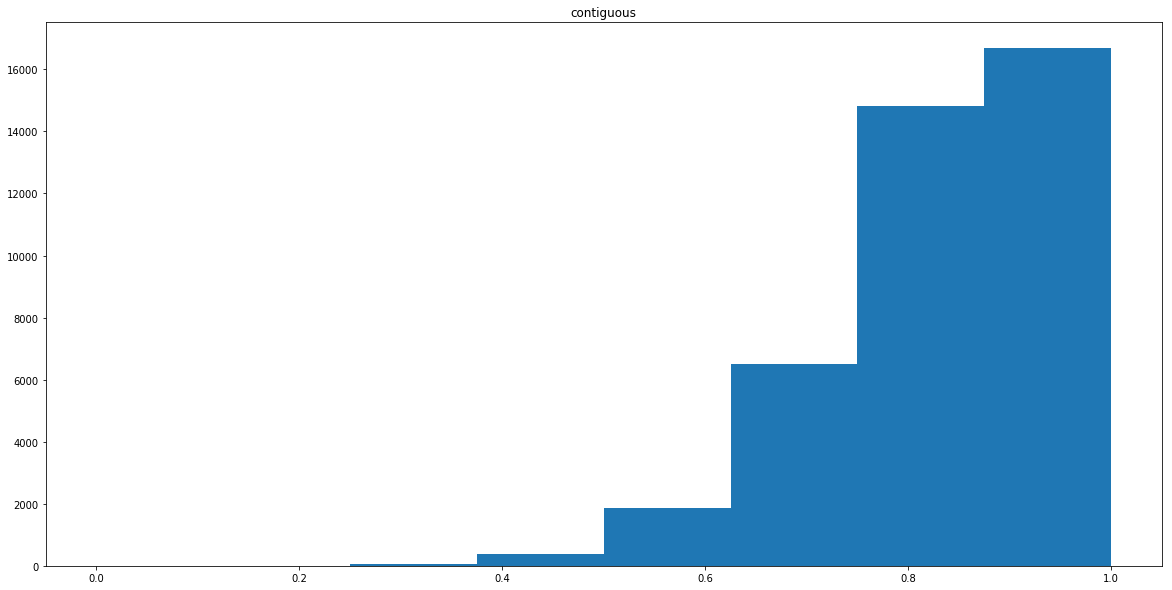

In [5]:
# Plot histogram of various methods across all permutations
visualization_method = plt.hist
method_list = [contiguous_distance]
subplot_list = [111]
title_list = ['contiguous']
evaluate_methods(method_list, [visualization_method]*len(method_list), subplot_list=subplot_list, title_list=title_list)

plt.show()

Plotting: 100%|██████████████████████████████████████████████████████████████████████████| 9/9 [00:21<00:00,  2.36s/it]


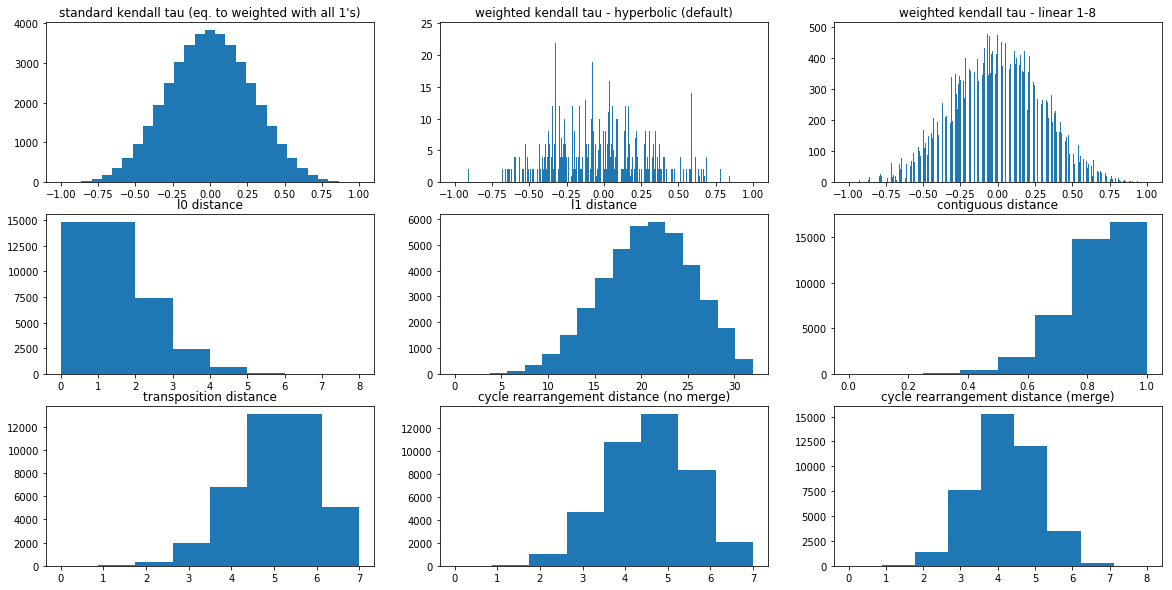

In [6]:
# Plot histogram of various methods across all permutations
visualization_method = plt.hist
method_list = [kendall_tau, kendall_tau_weighted, kendall_tau_weighted_2, 
               l0_matrix_distance, l1_matrix_distance, contiguous_distance,
               transposition_distance, cycle_rearrangement_distance_no_merge, cycle_rearrangement_distance]
subplot_list = [331, 332, 333, 334, 335, 336, 337, 338, 339]
title_list = ['standard kendall tau (eq. to weighted with all 1\'s)', 'weighted kendall tau - hyperbolic (default)', 
              'weighted kendall tau - linear 1-8', 'l0 distance', 'l1 distance', 'contiguous distance',
              'transposition distance', 'cycle rearrangement distance (no merge)','cycle rearrangement distance (merge)']
evaluate_methods(method_list, [visualization_method]*len(method_list), subplot_list=subplot_list, title_list=title_list)

plt.show()

## Evaluation of Candidate Methods

In the above section, it is clear that Kendall Tau has two critical properties: 1) it measures an element-wise representation of distance, and 2) it represents reflections as negative numbers. However, it does not appropriately capture orders which are contiguous but involve large shifts in subsets of the list (i.e. 5,6,7,8,1,2,3,4). For this reason, another metric is used and a 2D space is constructed. The Cycle Rearrangement Distance and Contiguous Distance metrics are evaluated now to determine if there are resolution differences. We see below that Contiguous Distance has slightly better resolution in terms of absolute discete states, but the probabilities are no longer centered. This may be desirable since the hypothesized state of interest is now maximally far from the probability mean.

(Note: Run all cells at the top of this notebook to initialize the proper prerequisite imports and code.)

Computing Permutations: 100%|██████████████████████████████████████████████████| 40320/40320 [00:18<00:00, 2199.67it/s]


method0: <function kendall_tau at 0x0000000023C12EB8>, method1: <function contiguous_distance at 0x0000000023C12E48>, title:kendall tau vs. contiguous_distance distance, size:141


Computing Permutations: 100%|██████████████████████████████████████████████████| 40320/40320 [00:20<00:00, 1995.64it/s]


method0: <function kendall_tau at 0x0000000023C12EB8>, method1: <function cycle_rearrangement_distance at 0x0000000023C12C18>, title:kendall tau vs. cycle rearrangement distance, size:138


Computing Permutations: 100%|██████████████████████████████████████████████████| 40320/40320 [00:17<00:00, 2242.37it/s]


method0: <function kendall_tau at 0x0000000023C12EB8>, method1: <function cycle_rearrangement_distance_no_merge at 0x0000000023C12D68>, title:kendall tau vs. cycle_rearrangement_distance_no_merge distance, size:138


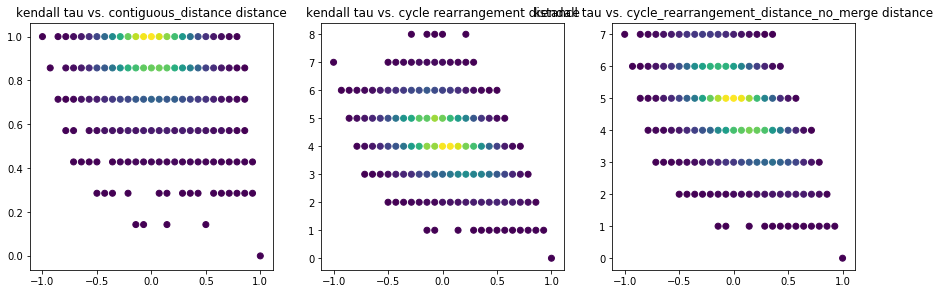

In [7]:
compare_methods(kendall_tau, contiguous_distance, hist=False, subplot=241, title='kendall tau vs. contiguous_distance distance')
compare_methods(kendall_tau, cycle_rearrangement_distance, hist=False, subplot=242, title='kendall tau vs. cycle rearrangement distance')
compare_methods(kendall_tau, cycle_rearrangement_distance_no_merge, hist=False, subplot=243, title='kendall tau vs. cycle_rearrangement_distance_no_merge distance')

## Comparison of Other Methods

As a follow-up we can compare many of the other methods using a similar schema. We can see quickly that other combinations are not as resolute and have undesirable properties compared to the above methods.

(Note: Run all cells at the top of this notebook to initialize the proper prerequisite imports and code.)

In [ ]:
# Compare all methods
compare_methods(kendall_tau, cycle_rearrangement_distance, hist=True, subplot=241, title='kendall tau vs. cycle rearrangement distance')
compare_methods(kendall_tau, transposition_distance, hist=True, subplot=242, title='kendall tau vs. transposition distance')
compare_methods(kendall_tau, l1_matrix_distance, hist=True, subplot=243, title='kendall tau vs. l1 matrix distance')
compare_methods(kendall_tau, l0_matrix_distance, hist=True, subplot=244, title='kendall tau vs. l0 matrix distance')
compare_methods(kendall_tau, cycle_rearrangement_distance, hist=False, subplot=245, title='kendall tau vs. cycle rearrangement distance')
compare_methods(kendall_tau, transposition_distance, hist=False, subplot=246, title='kendall tau vs. transposition distance')
compare_methods(kendall_tau, l1_matrix_distance, hist=False, subplot=247, title='kendall tau vs. l1 matrix distance')
compare_methods(kendall_tau, l0_matrix_distance, hist=False, subplot=248, title='kendall tau vs. l0 matrix distance')

plt.figure()

compare_methods(cycle_rearrangement_distance, transposition_distance, hist=True, subplot=231, title='cycle rearrangement vs. transposition')
compare_methods(cycle_rearrangement_distance, l1_matrix_distance, hist=True, subplot=232, title='cycle rearrangement vs. l1')
compare_methods(cycle_rearrangement_distance, l0_matrix_distance, hist=True, subplot=233, title='cycle rearrangement vs. l0')
compare_methods(transposition_distance, l1_matrix_distance, hist=True, subplot=234, title='transposition vs. l1')
compare_methods(transposition_distance, l0_matrix_distance, hist=True, subplot=235, title='transposition tau vs. l0')
compare_methods(l1_matrix_distance, l0_matrix_distance, hist=True, subplot=236, title='l1 vs. l0')

plt.figure()

compare_methods(cycle_rearrangement_distance, transposition_distance, hist=False, subplot=231, title='cycle rearrangement vs. transposition')
compare_methods(cycle_rearrangement_distance, l1_matrix_distance, hist=False, subplot=232, title='cycle rearrangement vs. l1')
compare_methods(cycle_rearrangement_distance, l0_matrix_distance, hist=False, subplot=233, title='cycle rearrangement vs. l0')
compare_methods(transposition_distance, l1_matrix_distance, hist=False, subplot=234, title='transposition vs. l1')
compare_methods(transposition_distance, l0_matrix_distance, hist=False, subplot=235, title='transposition tau vs. l0')
compare_methods(l1_matrix_distance, l0_matrix_distance, hist=False, subplot=236, title='l1 vs. l0')

print('showing plots...')

plt.show()

## Monte Carlo Test for Larger Permutations
This section shows how we can evaluate properties of our metrics as the permutation size increases using monte carlo simulation.

Under ideal conditions, the min and max values should remain consistent across all sizes. However, because the monte carlo will have lower and lower probability of hitting the min and max values, we may see systematic fluctuations on certain metrics.

In [ ]:
# Plot histogram of various methods across all permutations
visualization_method = plt.hist
method = contiguous_distance
number_of_perms = 10000
force_unique_perms = False  # Setting this to True drastically slows the process
length_list = [10, 20, 30, 40, 50, 60, 70, 300]
subplot_list = [241, 242, 243, 244, 245, 246, 247, 248]

mins = []
maxs = []
for l, s in zip(length_list, subplot_list):
    mi, ma = evaluate_methods_monte_carlo([method], [visualization_method], 
                                          size=l, perm_count=number_of_perms, force_unique=force_unique_perms, 
                                          subplot_list=[s], title_list=['monte carlo len={0}'.format(l)])
    mins.append(mi)
    maxs.append(ma)
mins = list_flatten_2d(mins)
maxs = list_flatten_2d(maxs)
print(mins)
print(maxs)
print(length_list)
plt.figure()
plt.scatter(length_list, mins)
plt.scatter(length_list, maxs)
plt.show()

## 3D Simulation of Trial-Over-Trial Data

This section simulates trial-over-trial changes in learning with no bias (i.e. randomly generated data).

In [39]:
# Test function for visualizing a combination of Kentall Tau and Cycle Rearrangement Distance
def simulate_trial_over_trial_3d(root_lut, hypo_lut, n_trials=4, n_participants=43,
    n_items=8,  # Note that this is hard coded elsewhere in target values
    n_interpolated_points=50, interval=33, weights=None, fontsize='x-large'):
    
    # Generate trial-over-trial interpoolated probability distributions
    lutA = root_lut
    lutB = hypo_lut
    if weights is None:
        weights = [(0.5, 0.5)] * n_trials

    trial_luts = []
    for i in range(0, n_trials):
        trial_lut = dict()
        for key in lutA:
            if not key in lutB:
                trial_lut[key] = lutA[key] * weights[i][0]
            else:
                trial_lut[key] = lutA[key] * weights[i][0] + lutB[key] * weights[i][1]
        trial_luts.append(trial_lut)
    trial_luts.reverse()
    
    # This is dummy data for the moment as we'll actually be sampling from a distribution instead of generating
    # permutations.
    multi_data = get_random_perms(n_participants * n_trials)
    lut = root_lut # get_ktcd_probability_lut(n_items)
    multi_data = [multi_data[i:i+n_trials] for i in range(0, len(multi_data), n_trials)] 

    '''
    Example Data
    multi_data = [
    [
        [4,5,1,2,3,6,8,7],
        [3,4,5,6,7,8,1,2],
        [1,2,3,5,6,4,7,8],
        [1,2,3,4,5,6,8,7]
    ],
    [
        [2,1,4,3,6,5,8,7],
        [4,3,2,5,1,6,7,8],
        [1,2,3,4,6,5,7,8],
        [1,2,3,4,5,6,7,8]
    ],
    [
        [8,7,6,5,3,4,2,1],
        [5,6,7,4,3,2,1,8],
        [1,2,4,3,5,6,8,7],
        [1,2,3,4,5,6,8,7]
    ]
    ]
    '''
    
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    
    keys = lut.keys()
    k0, k1 = np.transpose(keys)
    ax.scatter(k0, k1, lut.values(), c=lut.values(), s=16)
    
    # This function is used for animation
    def update_plot(i, data, scat, txt):
        txt.set_text('Trial:' + str(float(i)/float(n_interpolated_points) + 1))
        pts = []
        for d in data:
            pts.append(list(d[i]))
        scat._offsets3d = np.transpose(pts)
        return scat,

    rgb = cm.get_cmap('viridis')(np.linspace(0.0, 1.0, 4))[np.newaxis, :, :3][0]
    
    points_data = []
    start_points = []
    for data in tqdm(multi_data, desc="Processing Simulated Data"):
        # distsA = [kendall_tau_contiguity_distance(p) for p in data]
        
        dists = [sample_from_discrete_distribution(1 , trial_luts[idx])[0] for idx in range(0, len(data))]
        
        probs = [lut[d] for d in dists if d in lut.keys()]

        #for dat, dist, prob in zip(data, dists, probs):
        #    print('dist_prob({0})=({1},{2})'.format(dat, dist, prob))

        d0, d1 = np.transpose(dists)
        
        lerp_points_x = []
        lerp_points_y = []
        lerp_points_z = []
        for idx in range(0, len(d0) - 1):
            lerp_points_x += list(np.linspace(d0[idx], d0[idx + 1], n_interpolated_points, endpoint=True))
            lerp_points_y += list(np.linspace(d1[idx], d1[idx + 1], n_interpolated_points, endpoint=True))
            lerp_points_z += list(np.linspace(probs[idx], probs[idx + 1], n_interpolated_points, endpoint=True))

        point_data = zip(lerp_points_x, lerp_points_y, lerp_points_z)
        points_data.append(point_data)
        
        ax.scatter(d0, d1, probs, c=rgb, marker='s', s=50)
        start_points.append([d0[0], d1[0], probs[0]])
    
    x, y, z = np.transpose(start_points)
    scatter_plot = ax.scatter(x, y, z, c=['r'], marker='s', s=50)

    txt = ax.text2D(0.05, 0.95, "Trial 4", transform=ax.transAxes, size=fontsize)
    ani = animation.FuncAnimation(fig, update_plot, frames=len(lerp_points_x), interval=interval,
                              fargs=(points_data, scatter_plot, txt))
    
    # ani.save('animation.gif', fps=60)
    
    # equivalent to rcParams['animation.html'] = 'html5'
    rc('animation', html='html5')
    #rcParams['animation.html'] = 'html5'
    ani.to_html5_video()

    plt.show()
    
    return ani

In [ ]:
#%%capture
# Run the test code
num_items = 8
lut = get_ktcd_probability_lut(num_items)
anim = simulate_trial_over_trial_3d(lut, lut, n_items=num_items)

In [ ]:
anim

## Special Points

Some points are extremely low probability, containing only one possible permutation. We examine these now.

In [10]:
print('ktcd([1,2,3,4,5,6,7,8])={0}'.format(ktcd([1,2,3,4,5,6,7,8])))
print('ktcd([8,7,6,5,4,3,2,1])={0}'.format(ktcd([8,7,6,5,4,3,2,1])))
lut = get_ktcd_probability_lut(8)

ktcd([1,2,3,4,5,6,7,8])=(0.99999999999999978, 0.0)
ktcd([8,7,6,5,4,3,2,1])=(-0.99999999999999978, 1.0)


Computing Permutations for LUT: 100%|██████████████████████████████████████████| 40320/40320 [00:19<00:00, 2089.44it/s]


In [11]:
print('{0}, {1}'.format(lut[ktcd([1,2,3,4,5,6,7,8])], lut[ktcd([1,2,3,4,5,6,7,8])]*factorial(8)))
print('{0}, {1}'.format(lut[ktcd([8,7,6,5,4,3,2,1])], lut[ktcd([8,7,6,5,4,3,2,1])]*factorial(8)))
f8 = factorial(8)
specials = []
for key in lut:
    if lut[key]*f8 == 1.0:
        specials.append(key)
        print(key)
    

2.48015873016e-05, 1.0
2.48015873016e-05, 1.0
(0.99999999999999978, 0.0)
(-0.99999999999999978, 1.0)
(-0.71428571428571419, 0.42857142857142855)
(-0.14285714285714285, 0.14285714285714285)


In [12]:
specials

[(0.99999999999999978, 0.0),
 (-0.99999999999999978, 1.0),
 (-0.71428571428571419, 0.42857142857142855),
 (-0.14285714285714285, 0.14285714285714285)]

In [13]:
print_queue = []
for idx, perm in enumerate(tqdm(itools.permutations([1,2,3,4,5,6,7,8]), total=factorial(8), desc="Computing Permutations")):
        for s in specials:
            if (np.array(ktcd(perm)) == np.array(s)).all():
                print_queue.append('ktcd({0}) = {1}'.format(perm, s))
for p in print_queue:
    print(p)

Computing Permutations: 100%|███████████████████████████████████████████████████| 40320/40320 [01:13<00:00, 547.62it/s]


ktcd((1, 2, 3, 4, 5, 6, 7, 8)) = (0.99999999999999978, 0.0)
ktcd((5, 6, 7, 8, 1, 2, 3, 4)) = (-0.14285714285714285, 0.14285714285714285)
ktcd((7, 8, 5, 6, 3, 4, 1, 2)) = (-0.71428571428571419, 0.42857142857142855)
ktcd((8, 7, 6, 5, 4, 3, 2, 1)) = (-0.99999999999999978, 1.0)


In [14]:
print_queue = []
s = (0.0, 1.0)
for idx, perm in enumerate(tqdm(itools.permutations([1,2,3,4,5,6,7,8]), total=factorial(8), desc="Computing Permutations")):
        if (np.array(ktcd(perm)) == np.array(s)).all():
            print_queue.append('ktcd({0}) = {1}'.format(perm, s))

Computing Permutations: 100%|██████████████████████████████████████████████████| 40320/40320 [00:18<00:00, 2188.09it/s]


In [15]:
print(print_queue[int(len(print_queue)/2.)])

ktcd((4, 8, 2, 1, 5, 7, 6, 3)) = (0.0, 1.0)


In [16]:
print(ktcd([4,2,3,6,7,8,5,1]))
print(lut[ktcd([4,2,3,6,7,8,5,1])])

(0.14285714285714285, 0.5714285714285714)
0.00369543650794


## Hypothesized Distribution Generation

This section demonstrates how by mean-shifting and bounding the distribution, we can generate a hypothesized distribution which can illustrate the expected trial-over-trial learning if convergence to allocentric order is observed.

In [17]:
lut = get_ktcd_probability_lut(8)

Computing Permutations for LUT: 100%|██████████████████████████████████████████| 40320/40320 [00:17<00:00, 2294.04it/s]


In [18]:
covariance_multiplier = 9
size = 10000

mean = (np.mean(np.transpose(lut.keys())[0]), np.mean(np.transpose(lut.keys())[1]))
cov = np.cov(np.transpose(lut.keys()))

actual = get_bounded_multivariate_normal_samples(mean, cov, size, [-1, 1, 0, 1])
# np.random.multivariate_normal(mean, cov, size)
hypo = get_bounded_multivariate_normal_samples((1, 0), cov*covariance_multiplier, size, [-1, 1, 0, 1])
# np.random.multivariate_normal((1, 0), cov, size)

Note that by bounding the distributions, we shift the means closer towards the center. To correct this, we will want to average in a bias direction towards the original means.

[ 0.11368222  0.44620737]
[ 0.06124975  0.61594886]


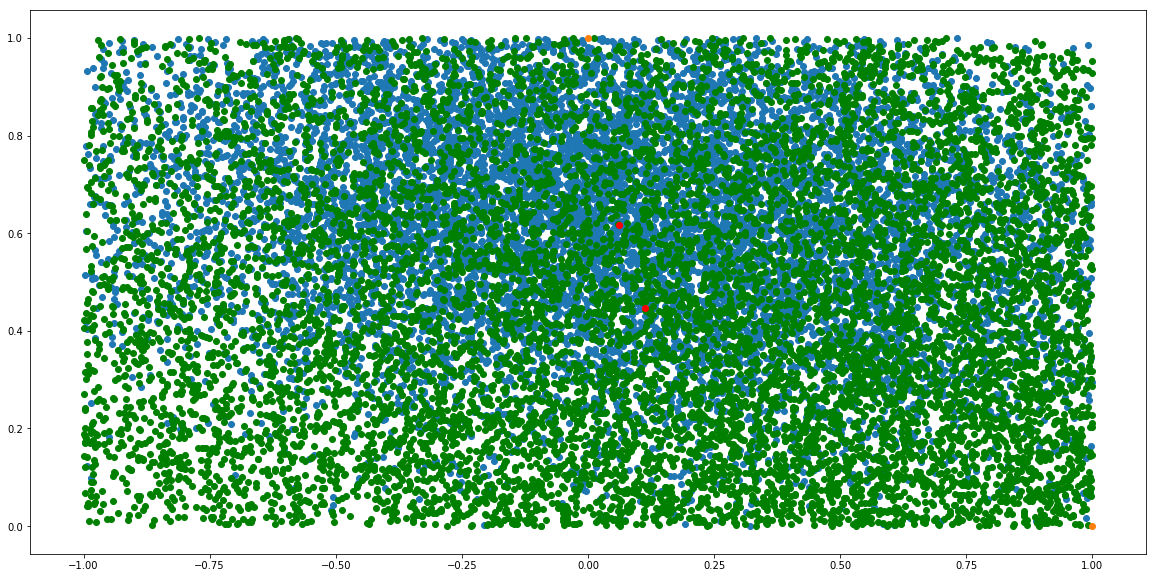

In [19]:
import matplotlib.pyplot as plt

plt.scatter(*np.transpose(actual))
plt.scatter(*np.transpose(hypo), c='g')

print(np.mean(hypo, axis=0))
print(np.mean(actual, axis=0))

plt.scatter([1, 0], [0, 1])
plt.scatter(*np.transpose([np.mean(hypo, axis=0), np.mean(actual, axis=0)]), c='r')
plt.show()

Processing Points: 100%|███████████████████████████████████████████████████████| 10000/10000 [00:09<00:00, 1033.91it/s]


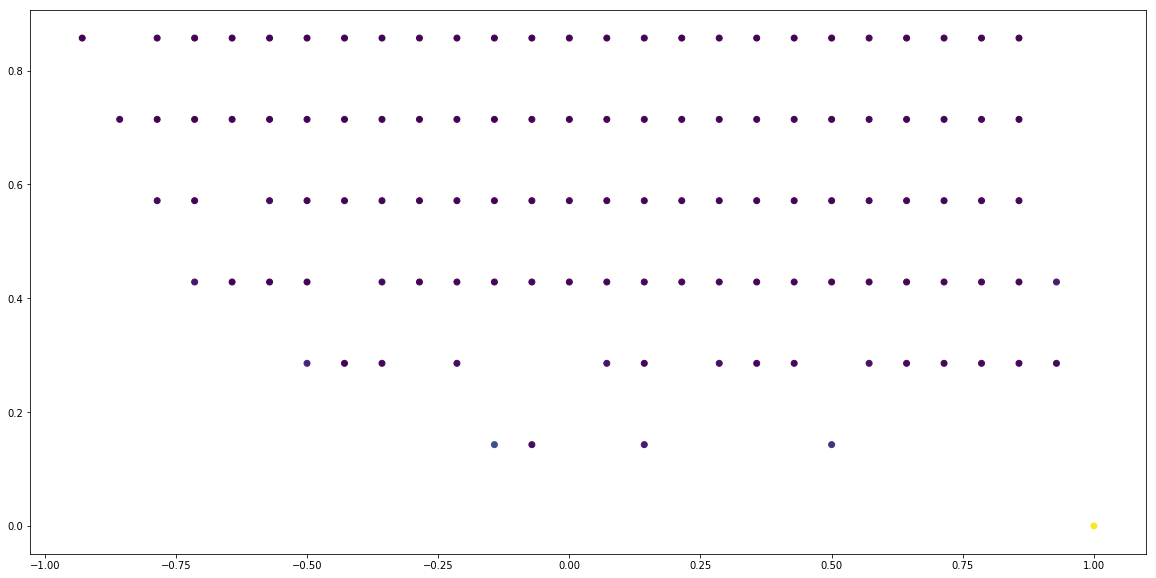

In [20]:
rs0, rs1 = np.transpose(round_to_direction_nd_multidimensional(hypo, lut.keys(), round_direction=[1, -1]))
rs_zipped = zip(rs0, rs1)
unique = []
unique_count = []
for r0, r1 in zip(rs0, rs1):
    if not (r0, r1) in unique:
        unique.append((r0, r1))
        unique_count.append(rs_zipped.count((r0, r1)))
rs0_unique, rs1_unique = np.transpose(unique)
plt.scatter(rs0_unique, rs1_unique, c=unique_count)
plt.show()

## Generate Probability LUT

Now that we've discretized the distribution, we can generate a probability table and visualize it.

In [21]:
hypo_prob_dist = dict()
total = sum(unique_count)
for u, uc in zip(unique, unique_count):
    hypo_prob_dist[u] = uc/float(total)
print(max(hypo_prob_dist.values()))

0.2462


In [22]:
hypo_prob_dist

{(-0.92857142857142849, 0.8571428571428571): 0.002,
 (-0.8571428571428571, 0.7142857142857143): 0.0061,
 (-0.78571428571428559, 0.5714285714285714): 0.0078,
 (-0.78571428571428559, 0.7142857142857143): 0.0027,
 (-0.78571428571428559, 0.8571428571428571): 0.0038,
 (-0.71428571428571419, 0.42857142857142855): 0.0161,
 (-0.71428571428571419, 0.5714285714285714): 0.0034,
 (-0.71428571428571419, 0.7142857142857143): 0.0029,
 (-0.71428571428571419, 0.8571428571428571): 0.0027,
 (-0.64285714285714279, 0.42857142857142855): 0.0034,
 (-0.64285714285714279, 0.7142857142857143): 0.0032,
 (-0.64285714285714279, 0.8571428571428571): 0.0024,
 (-0.5714285714285714, 0.42857142857142855): 0.0036,
 (-0.5714285714285714, 0.5714285714285714): 0.0078,
 (-0.5714285714285714, 0.7142857142857143): 0.0032,
 (-0.5714285714285714, 0.8571428571428571): 0.0037,
 (-0.49999999999999989, 0.2857142857142857): 0.0284,
 (-0.49999999999999989, 0.42857142857142855): 0.0043,
 (-0.49999999999999989, 0.5714285714285714): 0.0

In [23]:
%%capture
anim = simulate_trial_over_trial_3d(hypo_prob_dist, hypo_prob_dist);

In [24]:
anim

## Trial-Over-Trial Distribution Transition

Now that we have both distributions, we can animate a transition between the two using either a linear or exponential weighted learning curve. First, we generate these weights, then we generate a hypothesized data set which represents a transition in accordance with these weights between the random and allocentric distributions.

[(0.0, 1.0), (0.3333333333333333, 0.66666666666666674), (0.6666666666666666, 0.33333333333333337), (1.0, 0.0)]
[(0.0, 1.0), (0.059977795315114282, 0.94002220468488573), (0.26932087079731121, 0.73067912920268885), (1.0, 0.0)]


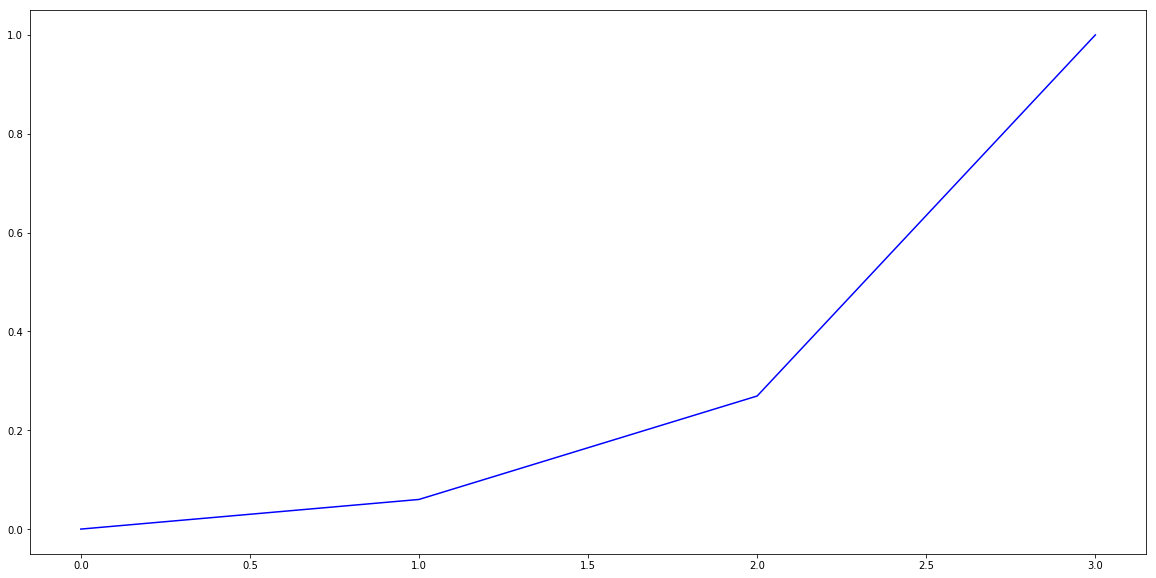

In [25]:
n = 4
linear_weights = zip([(float(x))/(n-1) for x in range(0, (n-1))],[np.abs(1-(float(x)/(n-1))) for x in range(0, n-1)]) + [(1.0, 0.0)]
print(linear_weights)

exp_growth_factor = 5
y0 = np.exp([xx/float(n)*exp_growth_factor for xx in range(0, n)]) - 1
y1 = [(z/(max(y0)-min(y0))) for z in y0]
y2 = [1 - x for x in y1]
exp_weights = zip(y1, y2)
print(exp_weights)

#plt.plot([0,1,2,3], np.transpose(linear_weights)[0], c='r')
plt.plot([0,1,2,3], np.transpose(exp_weights)[0], c='b')
plt.show()

In [40]:
%%capture
anim_linear = simulate_trial_over_trial_3d(lut, hypo_prob_dist, weights=linear_weights)

In [41]:
anim_linear

In [42]:
%%capture
anim_exp = simulate_trial_over_trial_3d(lut, hypo_prob_dist, weights=exp_weights)

In [43]:
anim_exp